# 2 - LeNet

In this notebook we will be implementing a modified version of [LeNet-5](http://yann.lecun.com/exdb/lenet/), a neural network model that uses convolutional neural network (CNN) layers and was designed for [classifying handwritten characters](http://yann.lecun.com/exdb/publis/pdf/lecun-01a.pdf). CNNs are ubiquitous in modern computer vision. Almost every neural network model for computer vision contains many CNN layers, also referred to as convolutional layers, thus they're an important concept to understand. We will explain how they work when we implement the model.

The image below shows the architecture of LeNet-5. It consists of two convolutional layers, each followed by a subsampling layer, and then three fully connected linear layers.

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/lenet5.png?raw=1)

Like the previous notebook we'll implement LeNet, measure its performance on the MNIST dataset.

Most of this notebook will be similar to the previous one thus we will skim over code that has been shown before. We can look at the previous notebook for a refresher if needed.

### Data Processing

As always, we'll import the modules we need...

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data as data

import torchvision.transforms as trans
import torchvision.datasets as datasets

from sklearn import decomposition
from sklearn import manifold
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

import copy
import random
import time

...set the random seed for reproducability...

In [2]:
SEED = 1234

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

...and calculate the mean and standard deviation across our training set so we can normalize our data.

In [3]:
ROOT = '.data'

train_data = datasets.MNIST(root = ROOT, train = True, download = True)

mean = train_data.data.float().mean() / 255
std = train_data.data.float().std() / 255

print(f'Calculated mean: {mean}')
print(f'Calculated std: {std}')

Calculated mean: 0.13066047430038452
Calculated std: 0.30810779333114624


Then, we'll define our transforms...

In [4]:
transforms = trans.Compose([
  trans.ToTensor(),
  trans.Normalize(mean = [mean], std = [std])])

...load our train and test data...

In [5]:
train_data = datasets.MNIST(
  root = ROOT, 
  train = True, 
  download = True, 
  transform = transforms)

test_data = datasets.MNIST(
  root = ROOT, 
  train = False, 
  download = True, 
  transform = transforms)

...and create a validation set from 10% of our training data.

Remember that the validation set should always be taken from the training data, and never the test data.

In [6]:
VALID_RATIO = 0.9

n_train_examples = int(len(train_data) * VALID_RATIO)
n_valid_examples = len(train_data) - n_train_examples

train_data, valid_data = data.random_split(train_data, [n_train_examples, n_valid_examples])

We'll print out the number of examples in the training/validation/test sets to ensure everything has been loaded correctly.

In [7]:
print(f'Number of training examples: {len(train_data)}')
print(f'Number of validation examples: {len(valid_data)}')
print(f'Number of testing examples: {len(test_data)}')

Number of training examples: 54000
Number of validation examples: 6000
Number of testing examples: 10000


The final part of the data processing stage is to create our dataloaders/iterators.

Again, we use a batch size of 64 and only shuffle the training data each epoch.

In [8]:
BATCH_SIZE = 64

train_iterator = data.DataLoader(train_data, shuffle = True, batch_size = BATCH_SIZE)
valid_iterator = data.DataLoader(valid_data, batch_size = BATCH_SIZE)
test_iterator = data.DataLoader(test_data, batch_size = BATCH_SIZE)

### Defining the Model

The LeNet architectures, and almost every modern neural network computer vision architecture makes use of convolutional neural network (CNN) layers. 

So, what is a CNN layer? Each convolutional layer has a number of *filters*, also commonly referred to as *kernels*. A filter is a (usually) square matrix that slides across the pixels in an image from left-to-right, top-to-bottom. At each "step", the filter performs a [convolution](https://en.wikipedia.org/wiki/Convolution) operation on the image. The output of the convolutional layer is the result of these convolutions after the filter's final "step". 

**Note:** in machine learning frameworks there aren't actually "steps", the result for every filter location is calculated at the same time, in parallel. This is a lot faster than actually stepping through the image, but thinking about it in terms of steps makes everything easier to visualize.

Let's have a look at a single 2x2 filter passing over an image. We'll pretend the image is 10x10 pixels in this example.

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/filter-mnist.png?raw=1)

The filter (red) slides over the pixels of the image, stepping one pixel at a time. The size of the steps is called the *stride*, and we use a stride of one in this implementation, which means the filter moves one pixel at a time horizontally and moves one pixel down once it reaches the end of a row. The result of the convolution operation (green) is a pixel in the filtered image. All of these convolutions produce a new, filtered image.

Notice how the image coming out of the CNN layer is smaller than the image coming into the CNN. This is because the 2x2 filter has only nine steps horizontally and vertically. If we wanted to keep the output image the same size as the input image we could add padding - usually black pixels - around our image. 

When we have no padding and a step size of one, the size of the output image is: 

$$\text{height}_{\text{out}} = \text{height}_{\text{in}} - \text{filter}_{\text{height}} + 1$$

$$\text{width}_{\text{out}} = \text{width}_{\text{in}} - \text{filter}_{\text{width}} + 1$$

How do we calculate the values of the output pixels using the filter? It's simply a multiply and add! Each of the input image pixels covered by a filter is multiplied by the filter's weight over that pixel. All of these products are then summed together to get the value of the pixel in the output image.

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/single-filter.png?raw=1)

The same weights are used by the filter over the whole image. The weights do not change depending on the filters location within the image. One nice thing about this is that the filters (and the convolutional layers themselves) are *translation invariant*, that means it doesn't matter where a feature (curve, edge, line) appears in an image, the convolutional layer will find all occurences of it. 

The weights for the filters, much like the weights of the linear layers in multilayer perceptrons, are learned via gradient descent and backpropagation.

Why are convolutional neural networks structured in this way? Filters applied across an image in this way can be used to detect patterns such as horizontal and vertical lines within an image. These patterns can be thought of as features of the image, which our CNN extracts. These extracted features can then be combined in further layers of the neural network with other extracted features and together create higher level features, e.g. a certain position and orientation of two lines make a cross, which can indicate the centre of a handwritten 4.

CNNs are also inspired by classic computer vision techniques, like [Sobel filters](https://en.wikipedia.org/wiki/Sobel_operator). Let's try manually choosing weights of a 3x3 filter to make Sobel filters and apply them to some of the MNIST digits to see what type of things our CNN layers can learn.

The `plot_filter` function takes in a batch of images and a two-dimensional filter and plots the output of that filter applied to all of the images.

In [9]:
def plot_filter(images, filter):
  images = torch.cat([i.unsqueeze(0) for i in images], dim = 0).cpu()
  filter = torch.FloatTensor(filter).unsqueeze(0).unsqueeze(0).cpu()
  
  n_images = images.shape[0]
  filtered_images = F.conv2d(images, filter)
  fig = plt.figure(figsize = (20, 5))
  
  for i in range(n_images):
    ax = fig.add_subplot(2, n_images, i+1)
    ax.imshow(images[i].squeeze(0), cmap = 'bone')
    ax.set_title('Original')
    ax.axis('off')

    image = filtered_images[i].squeeze(0)

    ax = fig.add_subplot(2, n_images, n_images+i+1)
    ax.imshow(image, cmap='bone')
    ax.set_title(f'Filtered')
    ax.axis('off');

We'll then get a batch of images to test our handwritten Sobel filters on. We get the images from the test set as they're easier to examine without the transforms applied to them.

In [10]:
N_IMAGES = 5
images = [image for image, label in [test_data[i] for i in range(N_IMAGES)]]

The first filter is for detecting horizontal lines.

We can see on the filtered images that the highest values (the whitest pixels) of the filtered image are where there is a horizontal line that is black on top and white below, e.g. the top of the 7 digit. The lowest values (the blackest pixels) of the filtered image are where there is a horizontal line that goes from white to black, e.g. the bottoms of all of the digits.

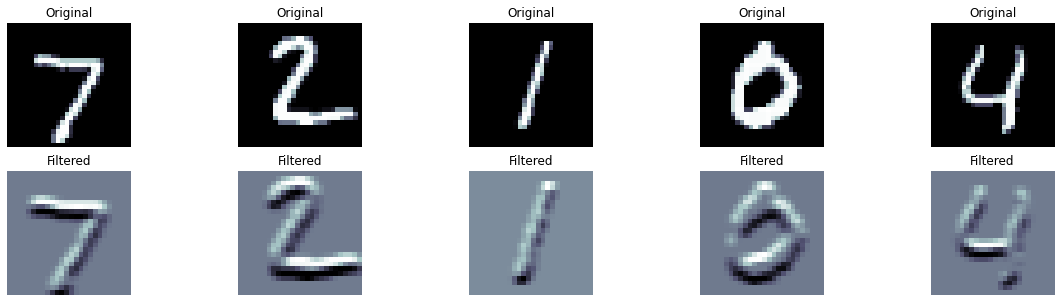

In [11]:
horizontal_filter = [
  [-1, -2, -1],
  [ 0,  0,  0],
  [ 1,  2,  1]]

plot_filter(images, horizontal_filter)

By swapping the first and last rows of the above filter, we get a filter that detects horizontal lines from white on top to black underneath.

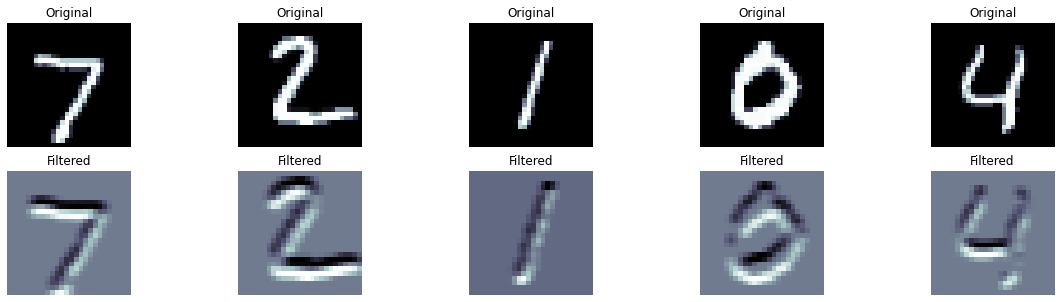

In [12]:
horizontal_filter = [
  [ 1,  2,  1],
  [ 0,  0,  0],
  [-1, -2, -1]]

plot_filter(images, horizontal_filter)

We can also design filters that detect vertical lines. 

Here's one that detects vertical lines that are black on the left and white on the right.

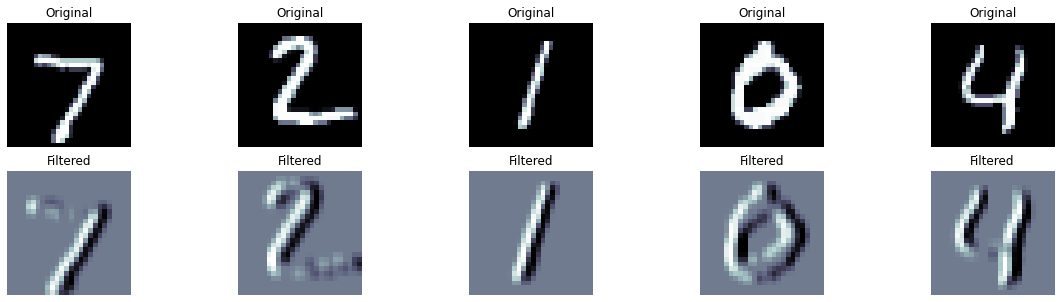

In [13]:
vertical_filter = [
  [-1, 0, 1],
  [-2, 0, 2],
  [-1, 0, 1]]

plot_filter(images, vertical_filter)

To get the opposite filter, one that detects vertical lines that are white on the left and black on the right, we swap the left and right columns.

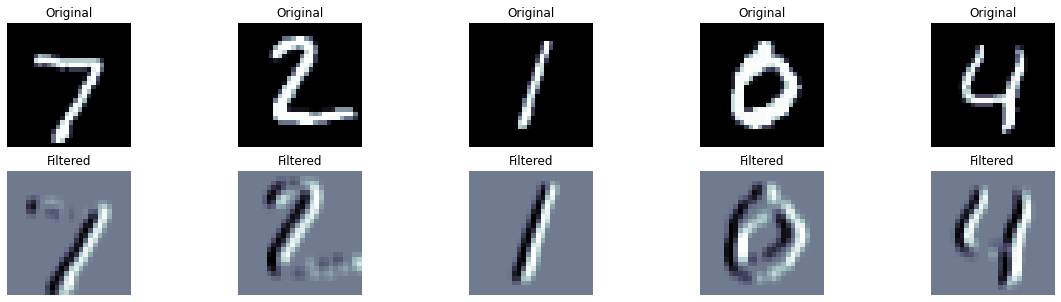

In [14]:
vertical_filter = [
  [1, 0, -1],
  [2, 0, -2],
  [1, 0, -1]]

plot_filter(images, vertical_filter)

Finally, we'll design a diagonal detecting filter. This one detects lines pointing towards the top right of the image.

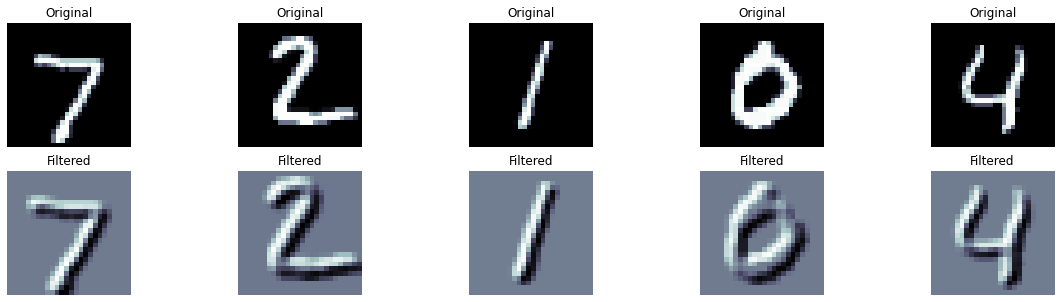

In [15]:
diagonal_filter = [
  [-2, -1, 0],
  [-1,  0, 1],
  [ 0,  1, 2]]

plot_filter(images, diagonal_filter)

The great thing about convolutional layers is that each layer doesn't just have a single filter. It has as many filters as you want. Each filter has their own set of weights, so (in theory) is learning to extract different features. 

The image below shows what happens when we use a convolutional layer with five filters. The original image with a single color channel (as it's black and white) has five filters applied to it to get five filtered images. These images are then stacked together to get what we can think of as a single image with five channels.  

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/multiple-filter-mnist.png?raw=1)

What about when you now want to pass this five channel filtered image to another convolutional layer? Now, that convolutional layer won't just have a height and a width, but it will also have a depth equal to the number of channels in the input image.

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/multiple-channel-mnist.png?raw=1)

As you can see, the filter has a height, width and depth of 2x2x5. All of the 20 pixel values covered by this filter are multiplied by the filter's weight and then summed. The result of this will have as many channels as there are filters, and a subsequent convolutional layer will have to have filters with a depth equal to that number of channels.

Hopefully that's enough on convolutional layers, but if not then there are [plenty](https://adeshpande3.github.io/A-Beginner%27s-Guide-To-Understanding-Convolutional-Neural-Networks/) of [other](https://cs231n.github.io/convolutional-networks/) resources [about](https://ujjwalkarn.me/2016/08/11/intuitive-explanation-convnets/) them [online](https://www.coursera.org/learn/convolutional-neural-networks).

Next, we'll talk about the subsampling layers. These are layers used to reduce the size/resolution of their input and are commonly applied to the output of convolutional layers. The most common two methods of subsampling are *max pooling* and *mean pooling* (also known as *average pooling*), and thus subsampling is often know as *pooling*.

Why do we want to reduce the resolution of the image? It speeds up our model, as convolution operations are expensive. If we subsample and half the size of our image before it passes into the next convolutional layer, that's a significant speed up.

Subsampling layers aren't too different to convolutional layers. They have a filter with a size and a stride. However, pooling layers do not have any parameters - weights and biases. They simply perform an operation on the image. Max pooling returns the maximum of the values covered by the filter and we can think of it as extracting the single most important feature under the filter. Mean/average pooling returns the mean/average of the values covered by the filter and we can think of it as equally weighting all features under the filter.

Let's look at a 2x2 pooling operation, with a stride of 2, over an image:

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/subsample-mnist.png?raw=1)

Commonly, and by default in PyTorch, the stride for the height and the width is the height and the width of the filter and each pixel is only seen by the pooling layer once, thus:

$$\text{height}_{\text{out}} = \frac{\text{height}_\text{in}}{\text{filter}_{\text{height}}}$$

$$\text{width}_{\text{out}} = \frac{\text{width}_\text{in}}{\text{filter}_{\text{width}}}$$

For max pooling, the value of the output for each filter location is:

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/single-pool.png?raw=1)

Similarly to convolutional layers, if the input image has more than one channel, the filter has a depth equal to the number of channels. Thus, if we did a max pool with a 5x5x6 filter (height and width of 5 and depth of 6), the output at each pixel would be the maximum value of all 150 pixels covered by the filter.

### Defining the Model

Now we've gone through all of the concepts we can implement our model.

![](https://github.com/bentrevett/pytorch-image-classification/blob/master/assets/lenet5.png?raw=1)

Our actual implementation is going to slightly differ from the actual LeNet architecture as it was built to handle 32x32 images, whereas the MNIST dataset consists of 28x28 images. We're also not going to use the Gaussian connections at the end, instead we'll just use a standard linear layer.

The first layer in our model is convolutional layer with 6 filters (PyTorch calls them `out_channels`) and a kernel size of 5. This turns our `[1, 28, 28]` image into `[6, 24, 24]`. We then downsample our image with a max pooling layer that has a filter size of 2 to get a `[6, 12, 12]` image. This is then passed through an activation function, ReLU in this case, which is applied elementwise and does not change the size of the image. 

Afterwards, we pass the image to the second convolutional layer with 16 filters that are 5x5x6, a height and width of 5 and a depth of 6 as our previous convolutional layer had 6 filters. This gives us an image size of `[16, 8, 8]` which we then max pool to half the heigth and width to `[16, 4, 4]` and then pass through another ReLU function.

We then flatten our `[16, 4, 4]` image to `[256]` and pass this through three linear layers. Each of the linear layers are followed by another ReLU, except for the last.

We return the results from the final linear layer.

Note that you should always apply your activation function **after** the pooling layer. You will get the exact same results if you apply the activation function before, however this means you will be applying your activation function to a larger number of inputs, increasing the computation required. Using the activation function after the image has been reduced in size means it will be applied to less inputs and thus use less computation.

In [16]:
class LeNet(nn.Module):
  def __init__(self, output_dim):
    super().__init__()
    #you have to define the functions which are needed to build our network.  
    #use nn.Conv2d for conv1 and conv2 (https://pytorch.org/docs/stable/generated/torch.nn.Conv2d.html)
    #use nn.Linear for fc_1, fc_2 and fc_3 (https://pytorch.org/docs/stable/generated/torch.nn.Linear.html)
    
    self.conv1 = nn.Conv2d(1,6,(5,5))
    self.conv2 = nn.Conv2d(6,16,(5,5))
    self.fc_1  = nn.Linear(16*4*4, 120) # 120 is a magic number
    self.fc_2  = nn.Linear(120, 84) # 84 also is a magic number
    self.fc_3  = nn.Linear(84, output_dim)

  def forward(self, x):
    #In here we will build the forward path of our network
    # x = [batch size, 1, 28, 28]
    
    #1. build your first convolution layer with conv1 function
    x = self.conv1(x)
    #x = [batch size, 6, 24, 24]
    
    #2. pool the first convolutoin layer using (https://pytorch.org/docs/stable/generated/torch.nn.functional.max_pool2d.html)
    x = F.max_pool2d(x, kernel_size=2)
    #x = [batch size, 6, 12, 12]
    
    #3. use the activation funciton for the first convolutoin layer (use self.input_fc function with relu (https://pytorch.org/docs/stable/generated/torch.nn.ReLU.html)) 
    x = F.relu(x)

    #4. build your second convolution layer with conv2 function
    x = self.conv2(x)
    #x = [batch size, 16, 8, 8]

    #5. pool the second convolutoin layer using
    x = F.max_pool2d(x, kernel_size=2)
    #x = [batch size, 16, 4, 4]

    #6. use relu activation funciton
    x = F.relu(x)
    h = x 

    #7. reshape the input (you can use the view method of a tensor) (https://pytorch.org/docs/stable/tensors.html#initializing-and-basic-operations)
    x = x.view(x.shape[0], -1)
    #x = [batch size, 16*4*4 = 256]
    
    #8. define the first fully connected layer fc_1
    x = self.fc_1(x)
    #x = [batch size, 120]

    #9. use relu
    x = F.relu(x)
    
    #10. define the second fc layer fc_2
    x = self.fc_2(x)
    #x = batch size, 84]

    #11. use relu
    x = F.relu(x)

    #12 define the third fc layer fc_3
    x = self.fc_3(x)
    #x = [batch size, output dim]

    return x, h

The rest of the notebook is similar to the previous ones. So, you cna use the previous notebook for the coming tasks.

We'll create an instance of the model...

In [17]:
OUTPUT_DIM = 10

# 1. create an instance of the LeNet class and call it model
model = LeNet(OUTPUT_DIM)

...and we will calculate the number of parameters. 

Notice that this model has significantly less parameters than the previous model: 44,000 parameters compared to 222,000.

In [18]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 44,426 trainable parameters


### Training the Model

We define our optimizer...

In [19]:
# define an optimizer (https://pytorch.org/docs/stable/generated/torch.optim.Adam.html#torch.optim.Adam) 
optimizer = optim.Adam(model.parameters())

...our loss function (which will also apply the softmax activation function)...

In [20]:
#define the criterion (https://pytorch.org/docs/stable/generated/torch.nn.CrossEntropyLoss.html)
criterion = nn.CrossEntropyLoss()

...define the device (to put our model and data on the GPU, if we have one)...

In [21]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

...place the model and criterion on the device...

In [22]:
# convert the model and the criterion to the device
model.to(device)
criterion.to(device)

CrossEntropyLoss()

...define a function to calculate accuracy...

In [23]:
def calculate_accuracy(y_pred, y):
  top_pred = y_pred.argmax(1, keepdim = True)
  correct = top_pred.eq(y.view_as(top_pred)).sum()
  acc = correct.float() / y.shape[0]
  return acc

...define a function that performs a training epoch...

In [24]:
def train(model, iterator, optimizer, criterion, device):
    
  epoch_loss = 0
  epoch_acc = 0
  
  model.train()
  
  #iterate over our data loader
  for (x, y) in iterator:
    # you task is to implement tasks 3 -> 9
    
    #3. use .to method
    x.to(device)
    y.to(device)

    #4. use zero_grad method of the optimizer
    optimizer.zero_grad()

    #5. use your model to pass the batch
    prediction, _ = model(x)

    #6. use the criterion to claculate the loss
    loss = criterion(prediction, y)

    #7. use calculate_accuracy function
    acc = calculate_accuracy(prediction, y)

    #8. use backward method of the loss
    loss.backward()
    
    #9. use step method of the optimizer
    optimizer.step()

    epoch_loss += loss.item()
    epoch_acc += acc.item()
      
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

...define a function that performs an evaluation epoch...

In [28]:
def evaluate(model, iterator, criterion, device):
  epoch_loss = 0
  epoch_acc = 0
  
  model.eval()
  
  with torch.no_grad():
    for (x, y) in iterator:
      #1. put the inputs in device: use .to method  
      x.to(device)
      y.to(device)

      #2. calculate prediciton: use your model to pass the batch 
      prediction, _ = model(x)

      #3. claculate the loss: use the criterion
      loss = criterion(prediction, y)

      #4. calculate accuracy: use calculate_accuracy function
      acc = calculate_accuracy(prediction, y)
        
      #5. update our metrics
      epoch_loss += loss.item()
      epoch_acc += acc.item()
      
  return epoch_loss / len(iterator), epoch_acc / len(iterator)

...define a function that tells us how long an epoch takes...

In [26]:
def epoch_time(start_time, end_time):
  elapsed_time = end_time - start_time
  elapsed_mins = int(elapsed_time / 60)
  elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
  return elapsed_mins, elapsed_secs

...and finally we can begin training!

Even though we have significantly less parameters, the model still takes around the same amount of time per epoch (convolutional layers are computationally expensive) and we train it a bit longer.

However, we beat the ~98% validation accuracy achieved by the multilayer perceptron model and achieve 99% validation accuracy.

In [29]:
EPOCHS = 20

best_valid_loss = float('inf')

for epoch in range(EPOCHS):
  
  start_time = time.monotonic()
  #tasks
  #1. calculate train_loss, train_acc (use the train function)
  train_loss, train_acc = train(model, train_iterator, optimizer, criterion, device)

  #2. calculate valid_loss, valid_acc (use the evaluate funciton)
  valid_loss, valid_acc = evaluate(model, valid_iterator, criterion, device)

  if valid_loss < best_valid_loss:
      best_valid_loss = valid_loss
      #3. save the model with the path 'tut2-model.pt' (https://pytorch.org/tutorials/beginner/saving_loading_models.html)
      torch.save(model.state_dict(), "tut2-model.pt")
  
  end_time = time.monotonic()

  epoch_mins, epoch_secs = epoch_time(start_time, end_time)
  
  print(f'Epoch: {epoch+1:02} | Epoch Time: {epoch_mins}m {epoch_secs}s')
  print(f'\tTrain Loss: {train_loss:.3f} | Train Acc: {train_acc*100:.2f}%')
  print(f'\t Val. Loss: {valid_loss:.3f} |  Val. Acc: {valid_acc*100:.2f}%')

tensor([[-2.4907e+00,  1.3295e+00,  5.3009e+00, -9.4880e-01, -2.8289e+00,
         -1.0845e-01, -2.3150e+00,  7.8021e-01, -4.3280e+00, -9.0399e+00],
        [-6.7254e+00,  7.3032e-01, -4.9763e+00,  4.3700e+00, -7.7996e+00,
          1.1007e+01, -4.2320e+00, -3.2175e+00, -4.2344e+00,  1.4681e+00],
        [-8.2164e+00, -1.3842e+00, -6.5454e+00,  3.5751e-01, -6.0997e+00,
          1.2978e+01, -4.5135e+00, -5.3322e+00, -6.4794e-01,  3.6320e+00],
        [-8.1496e+00,  2.2230e+00,  5.2255e-01,  1.4143e+01, -9.8690e+00,
         -4.9467e-01, -1.3564e+01,  4.0493e+00, -3.6554e+00,  4.3576e-01],
        [-5.8445e-01,  1.8505e+00, -4.0856e-01, -3.0581e+00,  1.2820e+00,
         -3.5557e+00, -7.5395e+00,  1.1192e+01, -2.6107e+00, -2.7583e-01],
        [-4.6223e+00, -3.0261e+00, -1.1491e+00,  5.9679e+00, -8.0650e+00,
         -1.1149e+00, -5.2792e+00, -3.7884e+00,  3.9945e+00,  3.7033e+00],
        [ 1.2763e+00, -6.0708e+00, -6.7610e+00, -3.7559e+00, -3.9462e-01,
         -1.4288e+00,  1.0343e+0

KeyboardInterrupt: 

We load the parameters which performed the best on the validation set and then evaluate our performance on the test set.

Just like the validation accuracy we get 99% test accuracy!

In [ ]:
model.load_state_dict(torch.load('tut2-model.pt'))
test_loss, test_acc = evaluate(model, test_iterator, criterion, device)

print(f'Test Loss: {test_loss:.3f} | Test Acc: {test_acc*100:.2f}%')

Test Loss: 0.038 | Test Acc: 98.89%


## Examining incorrect predictions
First, we'll get the model's predictions across the test set...

In [ ]:
def get_predictions(model, iterator, device):
  model.eval()

  images = []
  labels = []
  probs = []

  with torch.no_grad():
    for (x, y) in iterator:
      x = x.to(device)

      y_pred, _ = model(x)

      y_prob = F.softmax(y_pred, dim = -1)
       # top_pred = y_prob.argmax(1, keepdim = True)

      images.append(x.cpu())
      labels.append(y.cpu())
      probs.append(y_prob.cpu())

  images = torch.cat(images, dim = 0)
  labels = torch.cat(labels, dim = 0)
  probs = torch.cat(probs, dim = 0)

  return images, labels, probs

In [ ]:
images, labels, probs = get_predictions(model, test_iterator, device)

...and then get the predicted labels from the model's predictions.

In [ ]:
pred_labels = torch.argmax(probs, 1) # argmax: position where the value is max (1 means second dimension (columns))

tensor([7, 2, 1,  ..., 4, 5, 6])

Next, we'll find out which of our examples are correct...

In [ ]:
corrects = torch.eq(labels, pred_labels)

...then get all of the incorrect examples and sort them by descending confidence in their prediction.


In [ ]:
incorrect_examples = []

for image, label, prob, correct in zip(images, labels, probs, corrects):
    if not correct:
        incorrect_examples.append((image, label, prob))

incorrect_examples.sort(reverse = True, key = lambda example: torch.max(example[2], dim = 0).values)

We can then use this to plot the examples the model got wrong and was most confident about.

In [ ]:
def plot_most_incorrect(incorrect, n_images):
  rows = int(np.sqrt(n_images))
  cols = int(np.sqrt(n_images))

  fig = plt.figure(figsize = (20, 10))
  for i in range(rows*cols):
    ax = fig.add_subplot(rows, cols, i+1)
    image, true_label, probs = incorrect[i]
    true_prob = probs[true_label]
    incorrect_prob, incorrect_label = torch.max(probs, dim = 0)
    ax.imshow(image.view(28, 28).cpu().numpy(), cmap = 'bone')
    ax.set_title(f'true label: {true_label} ({true_prob:.3f})\n' \
                 f'pred label: {incorrect_label} ({incorrect_prob:.3f})')
    ax.axis('off')
  fig.subplots_adjust(hspace=0.5)

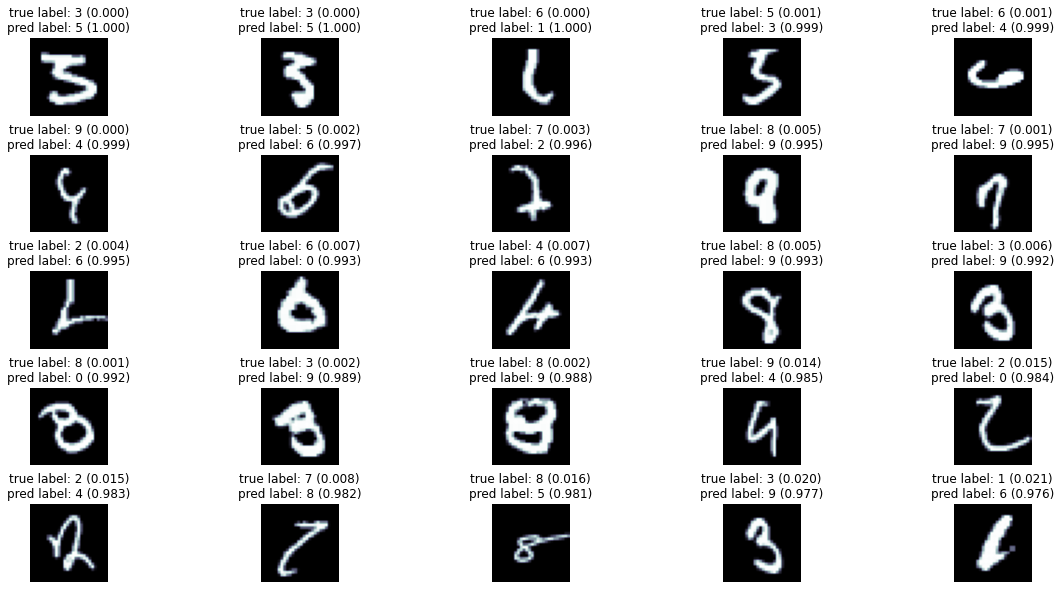

In [ ]:
N_IMAGES = 25

plot_most_incorrect(incorrect_examples, N_IMAGES)

The mistakes look pretty reasonable. All of the digits shown here are a bit off.

As mentioned in the previous notebook the model is always trained to be incredibly confident with its predictions, so it's not unreasonable for it to be incredibly confident when it's wrong.

### Conclusions

In this notebook we have shown: 
- loading Torchvision datasets
- loading transforms to augment and normalize our data
- what a convolutional layer is doing
- what a subsampling layer is doing
- defining a CNN (LeNet)
- training a model to achieve >98% accuracy
- viewing our model's mistakes